#  赛题十一 —— 论文复现自验报告

赛题内容：利用 MindQuantum 实现多基矢编码的变分量子算法

论文题目：[Variational Quantum Optimization with Multi-Basis Encodings](https://arxiv.org/pdf/2106.13304.pdf)
 
复现要求：利用 MindQuantum 实现 Multi-Basis Encoding 的变分量子算法来解决 maxcut 问题， 复现 fig2 中的变分量子线路，实现小于 10 个节点的 maxcut 图分割。

## 论文方案介绍

旅行推销员和最大割等 NP-hard 优化问题，在很多领域都很重要，比如运筹学、工程以及网络设计等。在这些问题的求解上，量子变分算法比经典算法具有更大的优势，从而体现出量子优势。
变分量子本征求解（VQE）是一种常见的量子变分算法，其通过梯度下降，最小化系统能量来制备编码着问题答案的量子态。

对量子系统进行经典模拟的计算量随着系统尺寸指数增加，且常规的 VQE 量子线路的宽度和深度也受所求问题的影响。
本论文提出了一种新的编码方式，只需采用常规 VQE 方法一半的比特资源，且在测量方面只需要单比特测量，从而降低了测量复杂度。

常规的 VQE 方法求解最大割问题的具体实现细节可参见 MindQuantum 的示例教程 [量子近似优化算法](https://www.mindspore.cn/mindquantum/docs/zh-CN/r0.6/quantum_approximate_optimization_algorithm.html)，此处不再赘述。其主要思路是通过最小化目标哈密顿量的期望值，来得到编码着答案的量子态。其映射方式为：



<img src="./src/VQE_for_MaxCut.png" alt="Drawing" style="width: 400px;" align="left"/>

目标哈密顿量为：
$$H=\Sigma_{j<i}^n\omega_{ij}^{zz}\sigma_i^z\sigma_j^z.$$
其中，$\omega_{ij}$ 表示图中顶点 $i$ 和 $j$ 之间的权重。哈密顿量只包含 $z$ 基底下的项。对于一个具有 $n$ 个顶点的图，要求其最大割，需要 $n$ 个量子比特，测量中亦需要双比特测量。

本论文提出一种新的编码方式，采用多基矢编码方式。如下图：

<img src="./src/MBE_for_MaxCut.png" alt="Drawing" style="width: 500px;" align="left"/>

对于 $n$ 个顶点的图，其将 $n/2$ 个顶点编码到 $z$ 基底，而另外 $n/2$ 个顶点编码到 $x$ 基底，从而只采用 $n/2$ 个比特就可以映射整个图。如果顶点数为奇数，则最后一个不再编码 $x$ 轴了。

其初始态采用 $|0\rangle_{n}$，而拟设线路采用多层如下所示的线路：

[WARNING] ME(931135:140597277590848,MainProcess):2023-10-17-19:53:43.648.486 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


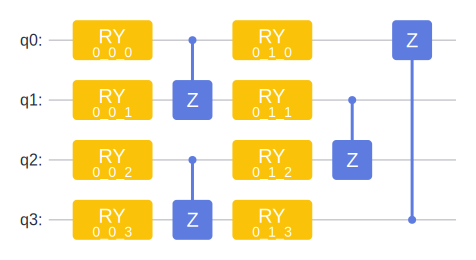

In [1]:
from mindquantum import *

def QLayer(qubit_num=4, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += RY(f'0_{qubit}').on(qubit)
    for qubit in range(0, qubit_num-1, 2):
        circ_ += Z.on(qubit+1, qubit)
    for qubit in range(qubit_num):
        circ_ += RY(f'1_{qubit}').on(qubit)
    for qubit in range(1, qubit_num-1, 2):
        circ_ += Z.on(qubit+1, qubit)
    circ_ += Z.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

qlayer = QLayer(qubit_num=4, prefix='0')
qlayer.svg()

用于更新网络参数的损失函数为：

$$L_{MBE}=\Sigma_{j<i}^{n/2}\omega_{ij}^{zz}\tanh(\langle\sigma_i^z\rangle)\tanh(\langle\sigma_j^z\rangle) + \Sigma_{j<i}^{n/2}\omega_{ij}^{xx}\tanh(\langle\sigma_i^x\rangle)\tanh(\langle\sigma_j^x\rangle) + \Sigma_{i,j}^{n/2}\omega_{ij}^{zx}\tanh(\langle\sigma_i^z\rangle)\tanh(\langle\sigma_j^x\rangle).$$

其中，$\tanh(x)$ 为经典计算机控制梯度下降时施加的非线性激活函数。

而最大割数的表达式为：

$$C_{MBE}(\theta, G)=\Sigma_{j<i}^{n/2}\frac{\omega_{ij}^{zz}}{2}[1-R(\langle\sigma_i^z\rangle)R(\langle\sigma_j^z\rangle)] + \Sigma_{j<i}^{n/2}\frac{\omega_{ij}^{xx}}{2}[1-R(\langle\sigma_i^x\rangle)R(\langle\sigma_j^x\rangle)] + \Sigma_{i,j}^{n/2}\frac{\omega_{ij}^{zx}}{2}[1-R(\langle\sigma_i^z\rangle)R(\langle\sigma_j^x\rangle)].$$

例如，对于一个 4 顶点的图，


<img src="./src/4_nodes_VQE.png" alt="Drawing" style="width: 200px;" align="left"/>

如果采用常规 VQE 编码方式，目标哈密顿为
$$ H=\omega_{12}\sigma_1^z\sigma_2^z + \omega_{34}\sigma_3^z\sigma_4^z + \omega_{13}\sigma_1^z\sigma_3^z.$$

而采用 MBE 编码，如下图编码到两个比特，其中，顶点 1 3 编码到第 1 个比特，而顶点 2 4 编码到第二个比特，且顶点 1 2 采用 $z$ 基底编码，而顶点 3 4 采用 $x$ 基底编码：


<img src="./src/4_nodes_MBE.png" alt="Drawing" style="width: 200px;" align="left"/>

其 MBE 损失函数写为

$$L_{MBE}=\omega_{12}^{zz}\tanh(\langle\sigma_1^z\rangle)\tanh(\langle\sigma_2^z\rangle) + \omega_{12}^{xx}\tanh(\langle\sigma_1^x\rangle)\tanh(\langle\sigma_2^x\rangle) + \omega_{11}^{zx}\tanh(\langle\sigma_1^z\rangle)\tanh(\langle\sigma_1^x\rangle).$$


而最大割数即为：

$$C_{MBE}(\theta, G)=\frac{\omega_{12}^{zz}}{2}[1-R(\langle\sigma_1^z\rangle)R(\langle\sigma_2^z\rangle)] + \frac{\omega_{34}^{xx}}{2}[1-R(\langle\sigma_3^x\rangle)R(\langle\sigma_4^x\rangle)] +\frac{\omega_{13}^{zx}}{2}[1-R(\langle\sigma_1^z\rangle)R(\langle\sigma_3^x\rangle)].$$

接下来，我们就以上述例子，在 MindQuantum 下进行实现。为简便起见，我们将所有边的权重 $\omega_{i,j}$ 都赋值为 1。

首先，我用经典穷举法得出正确结果，用于验证 MBE 方法结果的正确性。

one size: [0] cut= 2
one size: [1] cut= 1
one size: [1, 0] cut= 1
one size: [3] cut= 1
one size: [3, 0] cut= 3
one size: [3, 1] cut= 2
one size: [3, 2] cut= 1
one size: [2] cut= 2
one size: [2, 0] cut= 2
one size: [2, 1] cut= 3


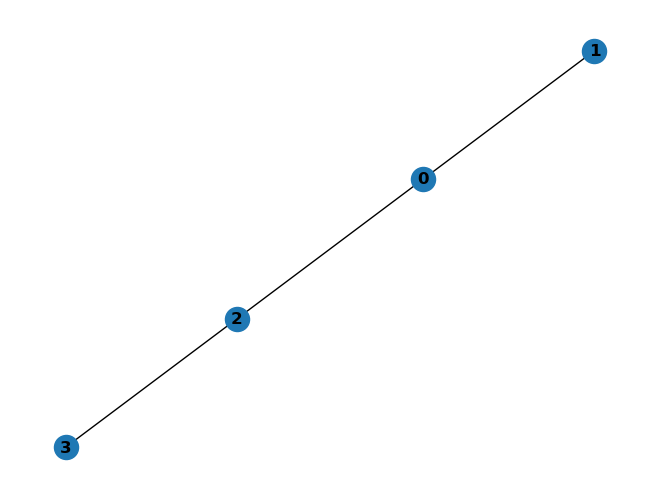

In [2]:
import networkx as nx

g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [3, 2])
nx.add_path(g, [2, 0])
nx.draw(g, with_labels=True, font_weight='bold') # 画出图

for i in g.nodes:
    print('one size:', [i], 'cut=', nx.cut_size(g, [i]))            # 一组 1 个顶点、另一组 3 个顶点的所有情况
    for j in range(i):
        print('one size:', [i, j], 'cut=', nx.cut_size(g, [i, j]))  # 一组 2 个顶点、另一组 2 个顶点的所有情况


以上结果显示，最大割数为 3。

下面采用量子 MBE 方法对同样的问题进行求解。

In [3]:
from mindquantum import *
import numpy as np
import mindspore as ms
from mindspore import nn, ops, Tensor
from mindspore.nn import Adam, TrainOneStepCell, LossBase
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")

def QLayer(qubit_num=4, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += RY(f'0_{qubit}').on(qubit)
    for qubit in range(0, qubit_num-1, 2):
        circ_ += Z.on(qubit+1, qubit)
    for qubit in range(qubit_num):
        circ_ += RY(f'1_{qubit}').on(qubit)
    for qubit in range(1, qubit_num-1, 2):
        circ_ += Z.on(qubit+1, qubit)
    circ_ += Z.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

qubit_num = 2
layer_num = 7

ansatz = Circuit()
for layer in range(layer_num):
    ansatz += QLayer(qubit_num=qubit_num, prefix=f'{layer}')

sim = Simulator('mqvector', ansatz.n_qubits)
ham =  [Hamiltonian(QubitOperator('Z0')), Hamiltonian(QubitOperator('X0')),
             Hamiltonian(QubitOperator('Z1')), Hamiltonian(QubitOperator('X1'))]
grad_ops = sim.get_expectation_with_grad(ham,
                                         ansatz)

class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.tanh = ops.Tanh()

    def construct(self, logits):
        out = self.tanh(logits)
        out = out[0] * out[2] + out[1] * out[3] + out[0] * out[1] 
        return self.get_loss(out)

class MyWithLossCell(nn.Cell):
   def __init__(self, backbone, loss_fn):
       super(MyWithLossCell, self).__init__(auto_prefix=False)
       self._backbone = backbone
       self._loss_fn = loss_fn

   def construct(self):
       out = self._backbone()
       return self._loss_fn(out)

   @property
   def backbone_network(self):
       return self._backbone

QuantumNet = MQAnsatzOnlyLayer(grad_ops)
loss = MyLoss()
net_with_criterion = MyWithLossCell(QuantumNet, loss)
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
net = TrainOneStepCell(net_with_criterion, opti)

for i in range(100):
    res = net()
    if i % 20 == 0:
        print(i, ': ', res)

round = ops.Round()
out = QuantumNet()
print((1 - round(out[0]) * round(out[2])) / 2 + (1 - round(out[1]) * round(out[3])) / 2 + (1 - round(out[0]) * round(out[1])) / 2)

0 :  0.5877196
20 :  -0.9304457
40 :  -1.0767412
60 :  -1.1096478
80 :  -1.1118505
3.0


由上面结果可知，求得的最大割数为 3， 这一结果和用经典方法得到的结果一致。

# 自验结果

## 1. 对不同顶点数的图结构求解最大割

为展示 MBE 算法的可靠性，我们分别对 3 - 10 个顶点的图进行了求解，都得到了与经典穷举法相一致的结果。该结果可通过执行 `main.ipynb` 中的 `主程序：0` 得到。

其中，对于顶点数为偶数的图，我们采用了 3-regular 图结构，而对顶点数为奇数的图，我们留一个顶点只有两条边，而其他顶点都有三条边。下面两图分别代表了顶点个数为偶数和奇数两种图结构的基本特征。

<img src="./src/even_graph.png" alt="Drawing" style="width: 340px;" align="left"/>


<img src="./src/odd_graph.png" alt="Drawing" style="width: 300px;" align="left"/>

## 2. 采用同一量子网络，求解不同图结构的最大割
此外，论文还指出，采用同一个量子神经网络，可以完成对不同图结构的最大割求解问题。我们也对这一结论进行了复现验证，该结果可通过执行 `main.ipynb` 中的 `主程序：1` 得到。以下为具体的计算结果。

In [ ]:
======================================================
3 顶点图， 边包括： [[0, 1], [1, 2], [2, 0], [0, 1]]
经典穷举法的最大割数为： 2
量子 MBE 法得到的最大割数为： 3
======================================================
4 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 0], [0, 2], [1, 3]]
经典穷举法的最大割数为： 4
量子 MBE 法得到的最大割数为： 4
======================================================
5 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 4], [4, 0], [0, 2], [1, 3]]
经典穷举法的最大割数为： 6
量子 MBE 法得到的最大割数为： 6
======================================================
6 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0], [0, 3], [1, 4], [2, 5]]
经典穷举法的最大割数为： 9
量子 MBE 法得到的最大割数为： 9
======================================================
7 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 0], [0, 3], [1, 4], [2, 5]]
经典穷举法的最大割数为： 9
量子 MBE 法得到的最大割数为： 9
======================================================
8 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 0], [0, 4], [1, 5], [2, 6], [3, 7]]
经典穷举法的最大割数为： 10
量子 MBE 法得到的最大割数为： 10
======================================================
9 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 0], [0, 4], [1, 5], [2, 6], [3, 7]]
经典穷举法的最大割数为： 12
量子 MBE 法得到的最大割数为： 12
======================================================
10 顶点图， 边包括： [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 0], [0, 5], [1, 6], [2, 7], [3, 8], [4, 9]]
经典穷举法的最大割数为： 15
量子 MBE 法得到的最大割数为： 15

## 3. 用户自定义图结构求解最大割

此项目支持用户自定义 2 个顶点以上的图结构的最大割求解。可根据输入边，自动确定图结构、量子比特数、目标哈密顿量等，计算并返回经典和 MBE 方法的求解结果。（注意，经典法目前只支持 3--10 个顶点的图最大割求解，如果顶点数大于 10 个，会提示不能计算，而量子 MBE 法则不受此限制）
代码已封装到 `custom_graph.py` 中，可通过执行以下代码进行调用求解：

In [1]:
from custom_graph import Custom_graph
edges =  [[0, 1], [1, 2], [9, 11]] # 示例图，用户可根据需要自定义图结构。支持的顶点数为 3-10
graph = Custom_graph(edges)
print(graph.exhaustion())
print(graph.MBE())

[WARNING] ME(931307:140174632527168,MainProcess):2023-10-17-19:54:54.162.572 [mindspore/run_check/_check_version.py:102] MindSpore version 2.1.0 and cuda version 11.8.89 does not match, CUDA version [['10.1', '11.1', '11.6']] are supported by MindSpore officially. Please refer to the installation guide for version matching information: https://www.mindspore.cn/install.


本程序经典穷举法支持的图顶点数范围为 [3, 10]， 您输入图的顶点数为 12，故不能计算。
量子 MBE 法得到的最大割数为：3


In [3]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum')

Software,Version
mindquantum,0.9.0
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Tue Oct 17 19:56:08 2023
